In [ ]:
#| hide
# no export documentation only   


# Gstreamer Python Documentation
> Gstreamer python library Docs
> Documenting use of [this](https://github.com/johnnewto/gstreamer-python) repo
> Forked from [this](https://github.com/jackersson/gstreamer-python) repo


In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
# skip_showdoc: true to avoid running cells when rendering docs, and skip_exec: true to skip this notebook when running tests. 
# this should be a raw cell 

In [ ]:
%%capture
from mavcom.imports import *   # TODO why is this relative import on nbdev_export?
import cv2
import gi
import numpy as np
from imutils import resize

from PIL import Image


import time
# from dataloader import LoadImages, resize
from pathlib import Path
# import logging

# gi.require_version('Gst', '1.0')


In [ ]:

from gstreamer import GstPipeline, GstContext, GstVidSrcValve, GstApp, Gst, GstVideo
import gstreamer.utils as gst_utils
from mavcom.utils import *
from mavcom.imports import *   # TODO why is this relative import on nbdev_export?
import time



In [ ]:
#| hide
from fastcore.utils import *
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
show_doc(GstVidSrcValve)

---

### GstVidSrcValve

>      GstVidSrcValve (command:str, leaky:bool=False, max_buffers_size:int=100,
>                      loglevel:gstreamer.gst_tools.LogLevels=20)

GstVideoSourceValve is a wrapper around a GStreamer pipeline that provides get and set methods for valve states.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| command | str |  | Gst_launch string |
| leaky | bool | False | If True -> use LeakyQueue |
| max_buffers_size | int | 100 | Max queue size |
| loglevel | LogLevels | 20 |  |

### Setup the pipeline commands
The valve is used to pause the video, this way we can multiplex the video stream so to conserve bandwidth


In [ ]:
show_doc(GstVidSrcValve.set_valve_state)

---

### GstVidSrcValve.set_valve_state

>      GstVidSrcValve.set_valve_state (valve_name:str, dropstate:bool)

Set the state of a valve in the pipeline

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| valve_name | str | Name of the valve in the pipeline |
| dropstate | bool | True = drop, False = pass |

The valve is used to pause the video, this way we can multiplex the video stream so to conserve bandwidth

In [ ]:
show_doc(GstVidSrcValve.get_valve_state)

---

### GstVidSrcValve.get_valve_state

>      GstVidSrcValve.get_valve_state (valve_name:str)

Get the state of a valve in the pipeline

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| valve_name | str | Name of the valve in the pipeline |

In [ ]:
DEFAULT_PIPELINE = gst_utils.to_gst_string([
            'videotestsrc pattern=ball is-live=true num-buffers=1000 ! tee name=t',
            't.',
            'queue leaky=2 ! valve name=myvalve drop=False ! video/x-raw,format=I420,width=640,height=480',
            'videoconvert',
            # 'x264enc tune=zerolatency noise-reduction=10000 bitrate=2048 speed-preset=superfast',
            'x264enc tune=zerolatency',
            'rtph264pay ! udpsink host=127.0.0.1 port=5000',
            't.',
            'queue leaky=2 ! videoconvert ! videorate drop-only=true ! video/x-raw,framerate=5/1,format=(string)BGR',
            'videoconvert ! appsink name=mysink emit-signals=true  sync=false async=false  max-buffers=2 drop=true ',
        ])

 dropstate = True, count = 10
 dropstate = False, count = 20
 dropstate = True, count = 30
 dropstate = False, count = 40
Got: 40 buffers


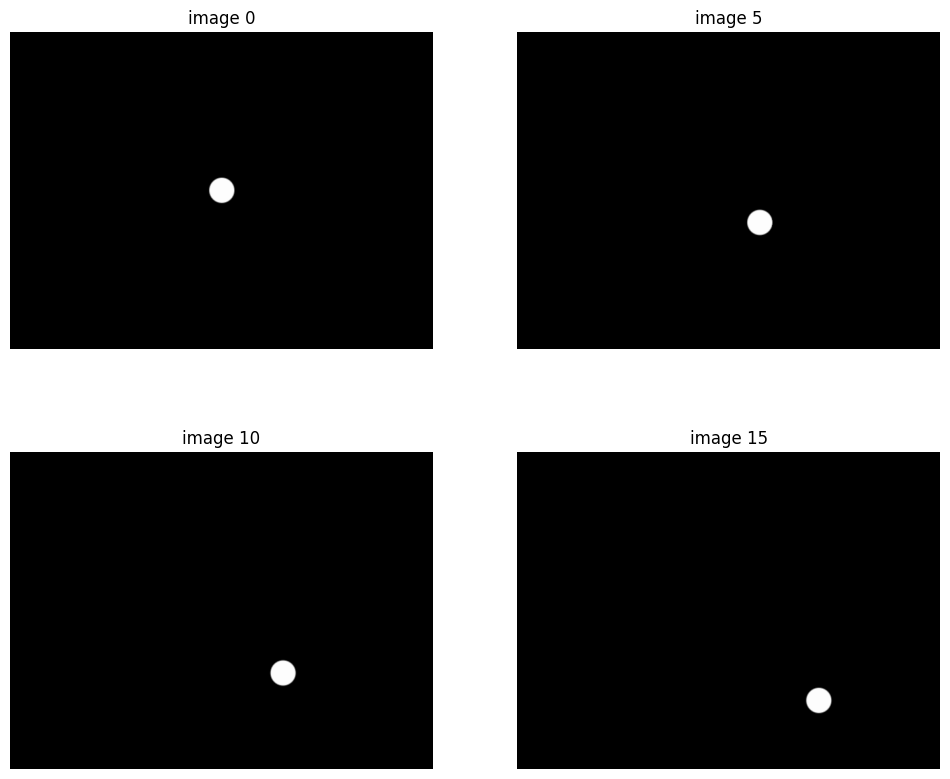

In [ ]:
command = DEFAULT_PIPELINE
width, height, num_buffers = 1920, 1080, 40
with GstVidSrcValve(command, leaky=True) as pipeline:
    buffers = []
    count = 0
    dropstate = False
    while len(buffers) < num_buffers:
        time.sleep(0.1)
        count += 1
        if count % 10 == 0:
            dropstate = not dropstate
            pipeline.set_valve_state("myvalve", dropstate)
            print(f' {dropstate = }, {count = }')
        buffer = pipeline.pop()
        if buffer:
            buffers.append(buffer)
            # if len(buffers) % 10 == 0:
            #     print(f'Got: {len(buffers)} buffers of {pipeline.queue_size}')
    print('Got: {} buffers'.format(len(buffers)))
    
_,axs = plt.subplots(2,2,figsize=(12,10))
for i,ax in enumerate(axs.flatten()): show_image(buffers[i*5].data, ax=ax, title=f'image {i*5}')

### Show the video on screen using two pipelines

In [ ]:
SRC_PIPELINE = gst_utils.to_gst_string([
            'videotestsrc pattern=ball is-live=true num-buffers=1000 ! video/x-raw,framerate=5/1 !  tee name=t',
            't.',
            'queue leaky=2 ! valve name=myvalve drop=False ! video/x-raw,format=I420,width=640,height=480',
            # 'textoverlay text="Frame: " valignment=top halignment=left shaded-background=true',
            # 'timeoverlay valignment=top halignment=right shaded-background=true',

            'videoconvert',
            # 'x264enc tune=zerolatency noise-reduction=10000 bitrate=2048 speed-preset=superfast',
            'x264enc tune=zerolatency',
            'rtph264pay ! udpsink host=127.0.0.1 port=5000',
            't.',
            'queue leaky=2 ! videoconvert ! videorate drop-only=true ! video/x-raw,framerate=5/1,format=(string)BGR',
            'videoconvert ! appsink name=mysink emit-signals=true  sync=false async=false  max-buffers=2 drop=true ',
        ])
print(SRC_PIPELINE)
SINK_PIPELINE = gst_utils.to_gst_string([
            'udpsrc port=5000 ! application/x-rtp, media=(string)video, clock-rate=(int)90000, encoding-name=(string)H264, payload=(int)96',
            'rtph264depay ! avdec_h264',
            'fpsdisplaysink',
            # 'autovideosink',
        ])

videotestsrc pattern=ball is-live=true num-buffers=1000 ! video/x-raw,framerate=5/1 !  tee name=t t. ! queue leaky=2 ! valve name=myvalve drop=False ! video/x-raw,format=I420,width=640,height=480 ! videoconvert ! x264enc tune=zerolatency ! rtph264pay ! udpsink host=127.0.0.1 port=5000 t. ! queue leaky=2 ! videoconvert ! videorate drop-only=true ! video/x-raw,framerate=5/1,format=(string)BGR ! videoconvert ! appsink name=mysink emit-signals=true  sync=false async=false  max-buffers=2 drop=true 


In [ ]:
num_buffers = 40
with GstPipeline(SINK_PIPELINE) as rcv_pipeline:
    with GstVidSrcValve(SRC_PIPELINE, leaky=True) as pipeline:
        buffers = []
        count = 0
        dropstate = False
        while len(buffers) < num_buffers:
            time.sleep(0.1)
            count += 1
            if count % 10 == 0:
                print(f'Count = : {count}')
                dropstate = not dropstate
                pipeline.set_valve_state("myvalve", dropstate)
            buffer = pipeline.pop()
            if buffer:

                buffers.append(buffer)
                if len(buffers) % 10 == 0:
                    print(f'Got: {len(buffers)} buffers of {pipeline.queue_size}')
        print('Got: {} buffers'.format(len(buffers)))

Count = : 10
Got: 10 buffers of 0
Count = : 20
Got: 20 buffers of 0
Count = : 30
Got: 30 buffers of 0
Count = : 40
Got: 40 buffers of 0
Got: 40 buffers


In [ ]:
# assert False, 'stop here'

In [ ]:
#| hide
# from nbdev import nbdev_export
# nbdev_export()